In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA   

Loading the Dataset

In [7]:
data = pd.read_csv("house_price_regression_dataset.csv")

print("Missing values per column:\n", data.isna().sum())
print("\nTotal duplicate rows:", data.duplicated().sum())


print(data.head())
print(data.describe())
print(data.info())

Missing values per column:
 Square_Footage          0
Num_Bedrooms            0
Num_Bathrooms           0
Year_Built              0
Lot_Size                0
Garage_Size             0
Neighborhood_Quality    0
House_Price             0
dtype: int64

Total duplicate rows: 0
   Square_Footage  Num_Bedrooms  Num_Bathrooms  Year_Built  Lot_Size  \
0            1360             2              1        1981  0.599637   
1            4272             3              3        2016  4.753014   
2            3592             1              2        2016  3.634823   
3             966             1              2        1977  2.730667   
4            4926             2              1        1993  4.699073   

   Garage_Size  Neighborhood_Quality   House_Price  
0            0                     5  2.623829e+05  
1            1                     6  9.852609e+05  
2            0                     9  7.779774e+05  
3            1                     8  2.296989e+05  
4            0              

Data Preprocessing and Splitting Data

In [ ]:
y_class = pd.cut(data['House_Price'], bins=3, labels=['low', 'medium', 'high'])
X_class = data[['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Neighborhood_Quality', 'Lot_Size', 'Garage_Size']]
X_temp, X_test_class, y_temp, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
X_train_class, X_val_class, y_train_class, y_val_class = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_class_scaled = scaler.fit_transform(X_train_class)
X_val_class_scaled = scaler.transform(X_val_class)
X_test_class_scaled = scaler.transform(X_test_class)
X_class_scaled = scaler.fit_transform(X_class)

KNN and Gridesearchcv

In [9]:
param_grid = {
    'n_neighbors': range(1, 31),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']   #1 all neighbors contribute equally 2-closer neighbors have more weight
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_class_scaled, y_class)

print("\nGridSearchCV Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy: {:.4f}".format(grid_search.best_score_))

results = pd.DataFrame(grid_search.cv_results_)
print(results)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

GridSearchCV Results:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}
Best CV Accuracy: 0.9010
     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.007664      0.000962         0.034360        0.002525   
1         0.008897      0.002470         0.009178        0.000347   
2         0.008477      0.002330         0.035418        0.001093   
3         0.006147      0.001810         0.008587        0.000971   
4         0.005929      0.000568         0.037986        0.004477   
..             ...           ...              ...             ...   
115       0.009973      0.007533         0.023509        0.014308   
116       0.004810      0.000789         0.043835        0.008597   
117       0.005330      0.000506         0.014683        0.001692   
118       0.004681      0.000813         0.040184        0.004012   
119       0.005140      0.000742         0.0155

Visualization is show :
 1. The relationship between model complexity (number of neighbors) and performance
2. The relative importance of different distance metrics and weighting schemes
3. The robustness of the optimal parameter selection

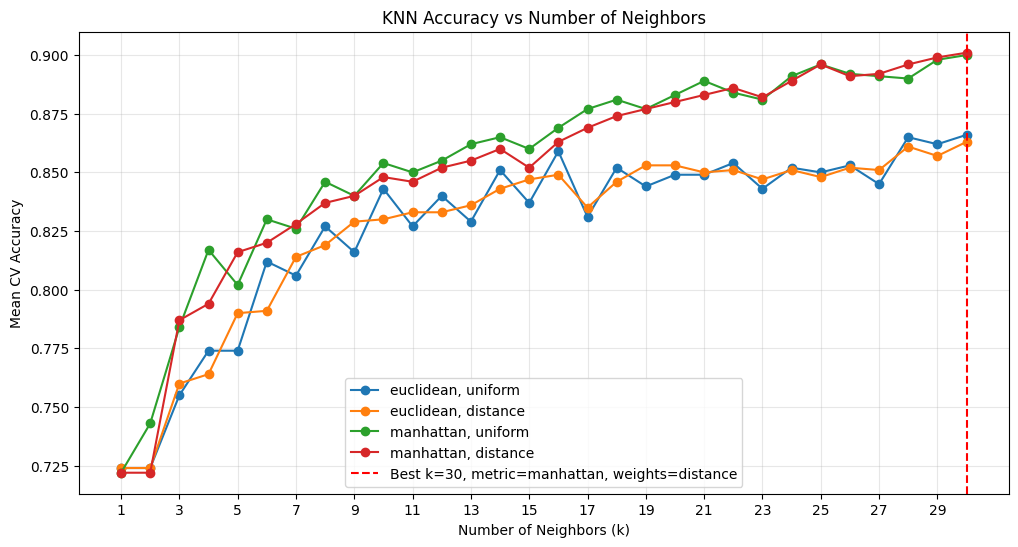

In [ ]:
plt.figure(figsize=(12, 6))
for metric in ['euclidean', 'manhattan']:
    for weight in ['uniform', 'distance']:
        subset = results[(results['param_metric'] == metric) & (results['param_weights'] == weight)]
        plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=f'{metric}, {weight}', marker='o')

best_k = grid_search.best_params_['n_neighbors']
best_metric = grid_search.best_params_['metric']
best_weights = grid_search.best_params_['weights']
plt.axvline(best_k, color='red', linestyle='--', label=f'Best k={best_k}, metric={best_metric}, weights={best_weights}')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean CV Accuracy')
plt.xticks(np.arange(1, 31, 2))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Test Set Performance with Best KNN
Evaluated the best KNN model using classification report and confusion matrix.  
Visualized confusion matrix with heatmap to assess prediction accuracy across classes


Test Set Performance with Best Model:
Classification Report:
              precision    recall  f1-score   support

        high       1.00      1.00      1.00        63
         low       1.00      1.00      1.00        54
      medium       1.00      1.00      1.00        83

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Confusion Matrix:


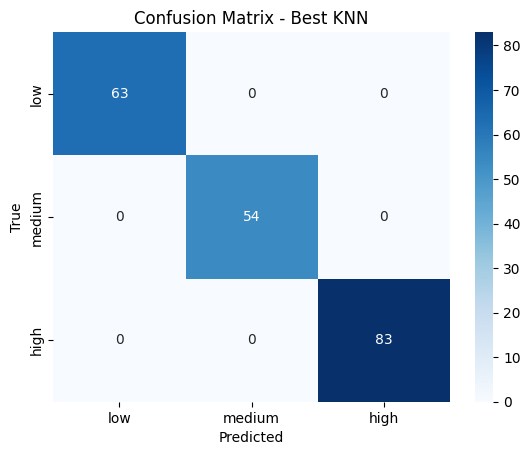

In [11]:

best_knn = grid_search.best_estimator_
y_pred_class = best_knn.predict(X_test_class_scaled)

print("\nTest Set Performance with Best Model:")
print("Classification Report:")
print(classification_report(y_test_class, y_pred_class))
print("Confusion Matrix:")
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['low', 'medium', 'high'], yticklabels=['low', 'medium', 'high'])
plt.title("Confusion Matrix - Best KNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

K-Fold Cross-Validation for Best KNN
Performed 5-fold cross-validation using a pipeline with `StandardScaler` and the best KNN model.  
Reported individual fold accuracies and calculated the mean accuracy across all folds

In [12]:

pipeline = make_pipeline(StandardScaler(), best_knn)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_class, y_class, cv=kfold, scoring='accuracy')
print("K-Fold CV Scores:", scores)
print(f"Mean Accuracy: {np.mean(scores):.4f}")

K-Fold CV Scores: [0.9   0.885 0.905 0.86  0.91 ]
Mean Accuracy: 0.8920


Data Visualization by Price Class
Visualized relationships between key features using a pair plot colored by `Price_Class`.  
Applied PCA to reduce dimensionality and plotted a 2D scatter plot to observe class separation

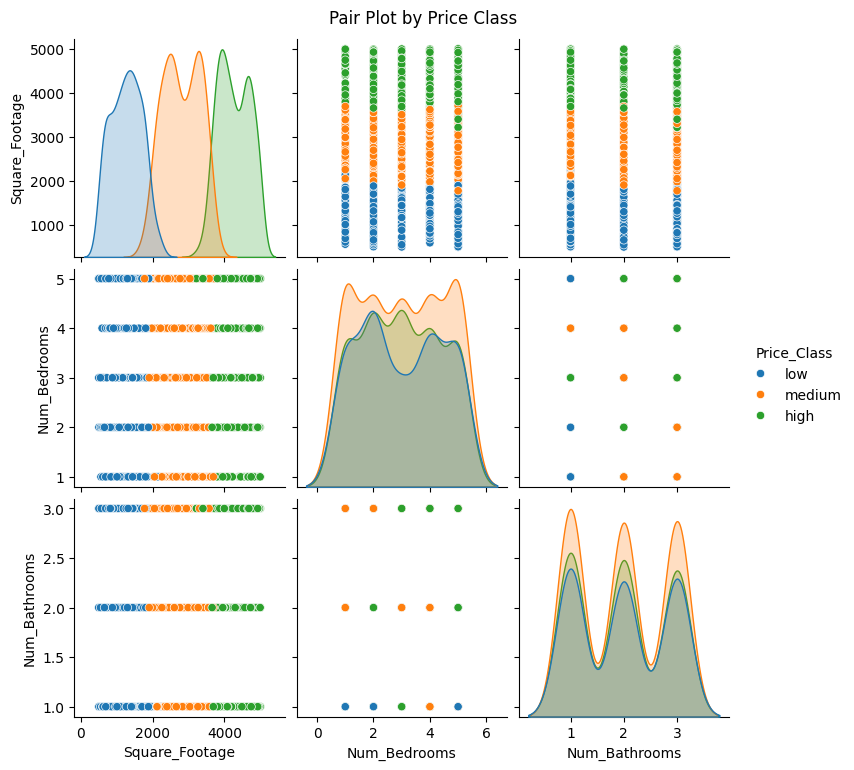

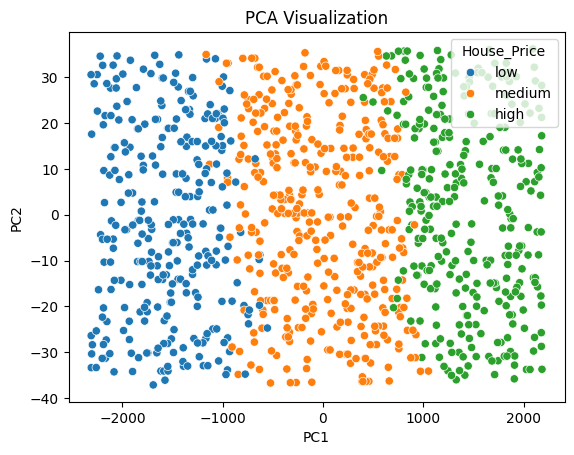

In [13]:
data_copy = data.copy()
data_copy['Price_Class'] = y_class
sns.pairplot(data_copy, hue='Price_Class', vars=['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms'])
plt.suptitle("Pair Plot by Price Class", y=1.02)
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_class)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_class)
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()